In [1]:
cd ../

/home/n_masuda/synth


In [2]:
import torch
from diffsynth.modules.harmor import Harmor
from diffsynth.modules.fm import FM2, FM3
from diffsynth.modules.generators import SineOscillator
from diffsynth.modules.envelope import ADSREnvelope
from diffsynth.modules.lfo import LFO
from diffsynth.modules.delay import ChorusFlanger, ModulatedDelay
from diffsynth.modules.reverb import DecayReverb
from diffsynth.processor import Add, Mix
from diffsynth.synthesizer import Synthesizer
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import numpy as np
import librosa.display
import tqdm
import glob, os

In [3]:
N_SAMPLES = 64000 # 4 seconds in 16kHz
NOTE_OFF = 0.75 # Note-off is 3 seconds in
DAT_SIZE = 20000
SAMPLERATE=16000
BATCH_SIZE=32

In [4]:
base_dir = '/home/n_masuda/Datasets/diffsynth_9-18/'
def make_dirs(synth_name):
    dat_dir = base_dir+synth_name
    audio_dir = os.path.join(dat_dir, 'audio')
    param_dir = os.path.join(dat_dir, 'param')
    os.makedirs(audio_dir, exist_ok=True)
    os.makedirs(param_dir, exist_ok=True)
    return audio_dir, param_dir

In [5]:
def render_dataset(synth, save_params, audio_dir, param_dir):
    count = 0
    break_flag = False
    skip_count = 0
    with torch.no_grad():
        with tqdm.tqdm(total=DAT_SIZE) as pbar:
            while True:
                if break_flag:
                    break
                audio, output = synth.uniform(BATCH_SIZE, N_SAMPLES, 'cuda')
                params = {k: output[synth.dag_summary[k]].cpu() for k in save_params}
                for j in range(BATCH_SIZE):
                    if count >= DAT_SIZE:
                        break_flag=True
                        break
                    aud = audio[j]
                    # remove silence
                    if aud.abs().max() < 0.05:
                        skip_count += 1
                        continue
                    p = {k:pv[j] for k, pv in params.items()}
                    param_path = os.path.join(param_dir, '{0:05}.pt'.format(count))
                    torch.save(p, param_path)
                    audio_path = os.path.join(audio_dir, '{0:05}.wav'.format(count))
                    sf.write(audio_path, aud.cpu().numpy(), samplerate=SAMPLERATE)
                    count+=1
                    pbar.update(1)
    print('skipped {0} quiet sounds'.format(skip_count))

harmor_fixed

1oscillator
pitch is fixed 

In [7]:
n_oscs = 1
harmor = Harmor(name='harmor', n_oscs=1)
enva = ADSREnvelope(name='enva', max_value=1.0, channels=1)
envc = ADSREnvelope(name='envc', channels=1)
dag = [
    (enva, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_A', 'attack': 'AT_A', 'decay': 'DE_A', 'sus_level': 'SU_A', 'release': 'RE_A', 'note_off': 'NO', 'noise_mag': 'NOISE_A'}),
    (envc, {'floor': 'CUT_FLOOR', 'peak': 'PEAK_C', 'attack': 'AT_C', 'decay': 'DE_C', 'sus_level': 'SU_C', 'release': 'RE_C', 'note_off': 'NO', 'noise_mag': 'NOISE_C'}),
    (harmor, {'amplitudes': 'enva', 'osc_mix': 'M_OSC', 'f0_hz': 'BFRQ', 'f0_mult': 'DUMMY', 'cutoff': 'envc', 'q': 'Q_FILT'}),
    ]
fixed_params = {'AMP_FLOOR':torch.zeros(1), 'NO': torch.ones(1)*NOTE_OFF, 'BFRQ': torch.ones(1)*440}
synth = Synthesizer(dag, fixed_params=fixed_params, static_params=['BFRQ', 'M_OSC', 'Q_FILT', 'NOISE_C', 'NOISE_A', 'DUMMY']).to('cuda')
save_params = ['harmor_amplitudes', 'harmor_osc_mix', 'harmor_cutoff', 'harmor_q']


In [8]:
audio_dir, param_dir = make_dirs('harmor_fixed')
render_dataset(synth, save_params, audio_dir, param_dir)

100%|██████████| 20000/20000 [05:43<00:00, 58.30it/s]skipped 4974 quiet sounds



## harmor_1oscfree
Setting:
- Oscillators
    - n_oscs: 1
    - Amplitude Envelope
    - Free frequency
- Filter
    - Cutoff Envelope
    - Fixed Q

In [ ]:
n_oscs = 1
harmor = Harmor(name='harmor', n_oscs=n_oscs)
enva = ADSREnvelope(name='enva', max_value=1.0, channels=n_oscs)
envc = ADSREnvelope(name='envc', channels=1)
dag = [
    (enva, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_A', 'attack': 'AT_A', 'decay': 'DE_A', 'sus_level': 'SU_A', 'release': 'RE_A', 'note_off': 'NO', 'noise_mag': 'NOISE_A'}),
    (envc, {'floor': 'CUT_FLOOR', 'peak': 'PEAK_C', 'attack': 'AT_C', 'decay': 'DE_C', 'sus_level': 'SU_C', 'release': 'RE_C', 'note_off': 'NO', 'noise_mag': 'NOISE_C'}),
    (harmor, {'amplitudes': 'enva', 'osc_mix': 'M_OSC', 'f0_hz': 'BFRQ', 'f0_mult': 'DUMMY', 'cutoff': 'envc', 'q': 'Q_FILT'}),
    ]
fixed_params = {'AMP_FLOOR':torch.zeros(1), 'NO': torch.ones(1)*NOTE_OFF}
synth = Synthesizer(dag, fixed_params=fixed_params, static_params=['BFRQ', 'M_OSC', 'Q_FILT', 'NOISE_C', 'NOISE_A']).to('cuda')
save_params = ['harmor_amplitudes', 'harmor_osc_mix', 'harmor_f0_hz', 'harmor_cutoff', 'harmor_q']


In [9]:
audio_dir, param_dir = make_dirs('harmor_1oscfree')
render_dataset(synth, save_params, audio_dir, param_dir)

100%|██████████| 20000/20000 [12:13<00:00, 27.26it/s]skipped 5736 quiet sounds



### Check files

20000 20000


dict_keys(['harmor_amplitudes', 'harmor_osc_mix', 'harmor_f0_hz', 'harmor_cutoff', 'harmor_q'])

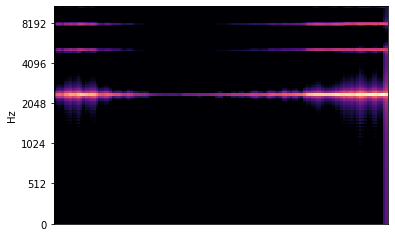

In [8]:
audio_files = glob.glob(audio_dir+'/*.wav')
param_files = glob.glob(param_dir+'/*.pt')
print(len(audio_files), len(param_files))
audio, sr = librosa.load(audio_files[0], sr=16000)
mel = librosa.feature.melspectrogram(y=audio, sr=16000, power=2.0)
mel_db = librosa.power_to_db(mel, np.max)
librosa.display.specshow(mel_db, sr=16000, y_axis='mel')
param = torch.load(param_files[0])
param.keys()

## harmor_2oscfree
Setting:
- Oscillators
    - n_oscs: 2
    - Separate Amplitude Envelope
    - Separate frequency
        - frequency is static
- Filter
    - Cutoff Envelope
    - Fixed Q

In [6]:
n_oscs = 2
harmor = Harmor(n_samples=N_SAMPLES, name='harmor', sep_amp=True, n_oscs=n_oscs)
enva = ADSREnvelope(name='enva', max_value=0.6, channels=2)
envc = ADSREnvelope(name='envc', channels=1)
dag = [
    (enva, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_A', 'attack': 'AT_A', 'decay': 'DE_A', 'sus_level': 'SU_A', 'release': 'RE_A', 'note_off': 'NO', 'noise_mag': 'NOISE_A'}),
    (envc, {'floor': 'CUT_FLOOR', 'peak': 'PEAK_C', 'attack': 'AT_C', 'decay': 'DE_C', 'sus_level': 'SU_C', 'release': 'RE_C', 'note_off': 'NO', 'noise_mag': 'NOISE_C'}),
    (harmor, {'amplitudes': 'enva', 'osc_mix': 'M_OSC', 'f0_hz': 'BFRQ', 'f0_mult': 'MULT', 'cutoff': 'envc', 'q': 'Q_FILT'}),
    ]
fixed_params = {'AMP_FLOOR':torch.zeros(1), 'NO': torch.ones(1)*NOTE_OFF}
synth = Synthesizer(dag, fixed_params=fixed_params, static_params=['BFRQ', 'MULT', 'M_OSC', 'Q_FILT', 'NOISE_A', 'NOISE_C']).to('cuda')
save_params = ['harmor_amplitudes', 'harmor_osc_mix', 'harmor_f0_hz', 'harmor_f0_mult', 'harmor_cutoff', 'harmor_q']


In [7]:
audio_dir, param_dir = make_dirs('harmor_2oscfree')
render_dataset(synth, save_params, audio_dir, param_dir)

100%|██████████| 20000/20000 [03:53<00:00, 85.72it/s]skipped 5915 quiet sounds



20000 20000


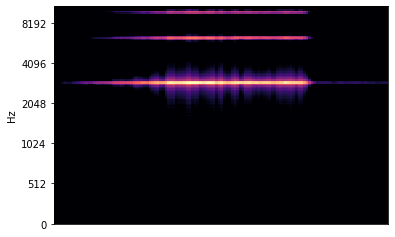

In [10]:
audio_files = glob.glob(audio_dir+'/*.wav')
param_files = glob.glob(param_dir+'/*.pt')
print(len(audio_files), len(param_files))
audio, sr = librosa.load(audio_files[0], sr=16000)
mel = librosa.feature.melspectrogram(y=audio, sr=16000, power=2.0)
mel_db = librosa.power_to_db(mel, np.max)
librosa.display.specshow(mel_db, sr=16000, y_axis='mel')

## FM2_free
- Parameters:
    - Carrier/Modulator Amplitudes
    - Carrier/Modulator Frequencies (static)

In [6]:
envm = ADSREnvelope(name='envm')
envc = ADSREnvelope(name='envc')
fmosc = FM2(n_samples=64000, name='fm2')
dag = [
    (envm, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_M', 'attack': 'AT_M', 'decay': 'DE_M', 'sus_level': 'SU_M', 'release': 'RE_M', 'note_off': 'NO', 'noise_mag': 'NOISE_M'}),
    (envc, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_C', 'attack': 'AT_C', 'decay': 'DE_C', 'sus_level': 'SU_C', 'release': 'RE_C', 'note_off': 'NO', 'noise_mag': 'NOISE_C'}),
    (fmosc, {'mod_amp': 'envm', 'car_amp': 'envc', 'mod_freq': 'FRQ_M', 'car_freq': 'FRQ_C'})
]
fixed_params = {'AMP_FLOOR':torch.zeros(1), 'NO': torch.ones(1)*NOTE_OFF}
synth = Synthesizer(dag, fixed_params=fixed_params, static_params=['FRQ_M', 'FRQ_C', 'NOISE_M', 'NOISE_C']).to('cuda')
save_params = ['fm2_mod_amp', 'fm2_car_amp', 'fm2_mod_freq', 'fm2_car_freq']


In [7]:
audio_dir, param_dir = make_dirs('fm2_free')
render_dataset(synth, save_params, audio_dir, param_dir)

100%|██████████| 20000/20000 [03:03<00:00, 108.71it/s]skipped 1024 quiet sounds



20000 20000


dict_keys(['fm2_mod_amp', 'fm2_car_amp', 'fm2_mod_freq', 'fm2_car_freq'])

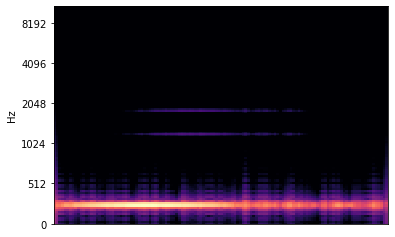

In [8]:
audio_files = glob.glob(audio_dir+'/*.wav')
param_files = glob.glob(param_dir+'/*.pt')
print(len(audio_files), len(param_files))
audio, sr = librosa.load(audio_files[0], sr=16000)
mel = librosa.feature.melspectrogram(y=audio, sr=16000, power=2.0)
mel_db = librosa.power_to_db(mel, np.max)
librosa.display.specshow(mel_db, sr=16000, y_axis='mel')
param = torch.load(param_files[0])
param.keys()

## FM2x2-free

FM2 added together

In [10]:
fm2_1 = FM2(n_samples=N_SAMPLES, name='fm2_1')
fm2_2 = FM2(n_samples=N_SAMPLES, name='fm2_2')
env1 = ADSREnvelope(name='env1')
env2 = ADSREnvelope(name='env2')
env3 = ADSREnvelope(name='env3')
env4 = ADSREnvelope(name='env4')
mix = Mix(name='add')
dag = [
    (env1, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_1', 'attack': 'AT_1', 'decay': 'DE_1', 'sus_level': 'SU_1', 'release': 'RE_1', 'note_off': 'NO', 'noise_mag': 'NOISE_1'}),
    (env2, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_2', 'attack': 'AT_2', 'decay': 'DE_2', 'sus_level': 'SU_2', 'release': 'RE_2', 'note_off': 'NO', 'noise_mag': 'NOISE_2'}),
    (env3, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_3', 'attack': 'AT_3', 'decay': 'DE_3', 'sus_level': 'SU_3', 'release': 'RE_3', 'note_off': 'NO', 'noise_mag': 'NOISE_3'}),
    (env4, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_4', 'attack': 'AT_4', 'decay': 'DE_4', 'sus_level': 'SU_4', 'release': 'RE_4', 'note_off': 'NO', 'noise_mag': 'NOISE_4'}),
    (fm2_1, {'mod_amp': 'env1', 'car_amp': 'env2', 'mod_freq': 'FRQ_1', 'car_freq': 'FRQ_2'}),
    (fm2_2, {'mod_amp': 'env3', 'car_amp': 'env4', 'mod_freq': 'FRQ_3', 'car_freq': 'FRQ_4'}),
    (mix, {'signal_a': 'fm2_1', 'signal_b': 'fm2_2', 'mix_a': 'MIX_A', 'mix_b': 'MIX_B'})
]
# avoid clipping
fixed_params = {'MIX_A': torch.ones(1)*0.5, 'MIX_B': torch.ones(1)*0.5, 'NO': torch.ones(1)*NOTE_OFF}
synth = Synthesizer(dag, fixed_params=fixed_params, static_params=['FRQ_1', 'FRQ_2', 'FRQ_3', 'FRQ_4', 'NOISE_1', 'NOISE_2', 'NOISE_3', 'NOISE_4', 'MIX_A', 'MIX_B']).to('cuda')
save_params = ['fm2_1_mod_amp', 'fm2_1_car_amp', 'fm2_2_mod_amp', 'fm2_2_car_amp', 'fm2_1_mod_freq', 'fm2_1_car_freq', 'fm2_2_mod_freq', 'fm2_2_car_freq']

In [11]:
audio_dir, param_dir = make_dirs('fm2x2_free')
render_dataset(synth, save_params, audio_dir, param_dir)

100%|██████████| 20000/20000 [03:44<00:00, 89.01it/s]skipped 1 quiet sounds



20000 20000


dict_keys(['fm2_1_mod_amp', 'fm2_1_car_amp', 'fm2_2_mod_amp', 'fm2_2_car_amp', 'fm2_1_mod_freq', 'fm2_1_car_freq', 'fm2_2_mod_freq', 'fm2_2_car_freq'])

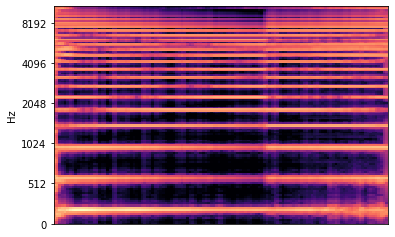

In [12]:
audio_files = glob.glob(audio_dir+'/*.wav')
param_files = glob.glob(param_dir+'/*.pt')
print(len(audio_files), len(param_files))
audio, sr = librosa.load(audio_files[0], sr=16000)
mel = librosa.feature.melspectrogram(y=audio, sr=16000, power=2.0)
mel_db = librosa.power_to_db(mel, np.max)
librosa.display.specshow(mel_db, sr=16000, y_axis='mel')
param = torch.load(param_files[0])
param.keys()

## FM2 half

- Carrier Frequency is fixed

In [22]:
envm = ADSREnvelope(name='envm')
envc = ADSREnvelope(name='envc')
fmosc = FM2(n_samples=64000, name='fm2')
dag = [
    (envm, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_M', 'attack': 'AT_M', 'decay': 'DE_M', 'sus_level': 'SU_M', 'release': 'RE_M', 'note_off': 'NO', 'noise_mag': 'NOISE_M'}),
    (envc, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_C', 'attack': 'AT_C', 'decay': 'DE_C', 'sus_level': 'SU_C', 'release': 'RE_C', 'note_off': 'NO', 'noise_mag': 'NOISE_C'}),
    (fmosc, {'mod_amp': 'envm', 'car_amp': 'envc', 'mod_freq': 'FRQ_M', 'car_freq': 'FRQ_C'})
]
fixed_params = {'AMP_FLOOR':torch.zeros(1), 'NO': torch.ones(1)*NOTE_OFF, 'FRQ_C': torch.ones(1)*440}
synth = Synthesizer(dag, fixed_params=fixed_params, static_params=['FRQ_M', 'FRQ_C', 'NOISE_M', 'NOISE_C']).to('cuda')
save_params = ['fm2_mod_amp', 'fm2_car_amp', 'fm2_mod_freq']


In [23]:
audio_dir, param_dir = make_dirs('fm2_half')
render_dataset(synth, save_params, audio_dir, param_dir)

100%|██████████| 20000/20000 [05:17<00:00, 63.02it/s] skipped 960 quiet sounds



20000 20000
dict_keys(['fm2_mod_amp', 'fm2_car_amp', 'fm2_mod_freq']) tensor([[0.8136]])


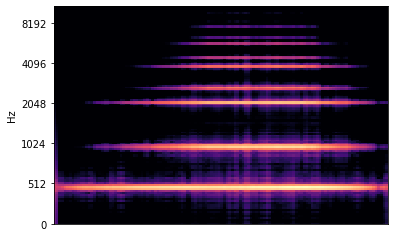

In [32]:
audio_files = glob.glob(audio_dir+'/*.wav')
param_files = glob.glob(param_dir+'/*.pt')
print(len(audio_files), len(param_files))
audio, sr = librosa.load(audio_files[5], sr=16000)
mel = librosa.feature.melspectrogram(y=audio, sr=16000, power=2.0)
mel_db = librosa.power_to_db(mel, np.max)
librosa.display.specshow(mel_db, sr=16000, y_axis='mel')
param = torch.load(param_files[5])
print(param.keys(), param['fm2_mod_freq'])

## Harmor_cf
Harmor_2oscfree with modulated delay
predict phase every frame

In [6]:
n_oscs = 2
harmor = Harmor(n_samples=N_SAMPLES, name='harmor', sep_amp=True, n_oscs=n_oscs)
enva = ADSREnvelope(name='enva', max_value=0.6, channels=2)
envc = ADSREnvelope(name='envc', channels=1)
cf = ChorusFlanger(name='cf', sr=SAMPLERATE)
dag = [
    (enva, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_A', 'attack': 'AT_A', 'decay': 'DE_A', 'sus_level': 'SU_A', 'release': 'RE_A', 'note_off': 'NO', 'noise_mag': 'NOISE_A'}),
    (envc, {'floor': 'CUT_FLOOR', 'peak': 'PEAK_C', 'attack': 'AT_C', 'decay': 'DE_C', 'sus_level': 'SU_C', 'release': 'RE_C', 'note_off': 'NO', 'noise_mag': 'NOISE_C'}),
    (harmor, {'amplitudes': 'enva', 'osc_mix': 'M_OSC', 'f0_hz': 'BFRQ', 'f0_mult': 'MULT', 'cutoff': 'envc', 'q': 'Q_FILT'}),
    (cf, {'audio': 'harmor', 'delay_ms': 'CF_DELAY', 'rate': 'CF_RATE', 'depth': 'CF_DEPTH', 'mix': 'CF_MIX'})
    ]
fixed_params = {'AMP_FLOOR':torch.zeros(1), 'NO': torch.ones(1)*NOTE_OFF}
synth = Synthesizer(dag, fixed_params=fixed_params, static_params=['BFRQ', 'MULT', 'M_OSC', 'Q_FILT', 'NOISE_A', 'NOISE_C', 'CF_DELAY', 'CF_RATE', 'CF_DEPTH', 'CF_MIX']).to('cuda')
save_params = ['harmor_amplitudes', 'harmor_osc_mix', 'harmor_f0_hz', 'harmor_f0_mult', 'harmor_cutoff', 'harmor_q', 'cf_delay_ms', 'cf_rate', 'cf_depth', 'cf_mix']


In [7]:
audio_dir, param_dir = make_dirs('harmor_cf_2')
render_dataset(synth, save_params, audio_dir, param_dir)

100%|██████████| 20000/20000 [16:07<00:00, 20.68it/s]skipped 6584 quiet sounds



20000 20000


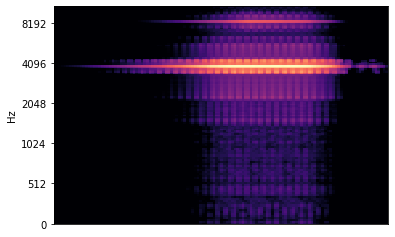

In [18]:
audio_files = glob.glob(audio_dir+'/*.wav')
param_files = glob.glob(param_dir+'/*.pt')
print(len(audio_files), len(param_files))
audio, sr = librosa.load(audio_files[12], sr=16000)
mel = librosa.feature.melspectrogram(y=audio, sr=16000, power=2.0)
mel_db = librosa.power_to_db(mel, np.max)
librosa.display.specshow(mel_db, sr=16000, y_axis='mel')

In [7]:
n_oscs = 2
harmor = Harmor(n_samples=N_SAMPLES, name='harmor', sep_amp=True, n_oscs=n_oscs)
enva = ADSREnvelope(name='enva', max_value=0.6, channels=2)
envc = ADSREnvelope(name='envc', channels=1)
md_lfo = LFO(name='md_lfo', n_secs=N_SAMPLES/SAMPLERATE, rate_range=(0.1, 10.0))
md = ModulatedDelay(name='md', sr=SAMPLERATE)
dag = [
    (enva, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_A', 'attack': 'AT_A', 'decay': 'DE_A', 'sus_level': 'SU_A', 'release': 'RE_A', 'note_off': 'NO', 'noise_mag': 'NOISE_A'}),
    (envc, {'floor': 'CUT_FLOOR', 'peak': 'PEAK_C', 'attack': 'AT_C', 'decay': 'DE_C', 'sus_level': 'SU_C', 'release': 'RE_C', 'note_off': 'NO', 'noise_mag': 'NOISE_C'}),
    (harmor, {'amplitudes': 'enva', 'osc_mix': 'M_OSC', 'f0_hz': 'BFRQ', 'f0_mult': 'MULT', 'cutoff': 'envc', 'q': 'Q_FILT'}),
    (md_lfo, {'rate': 'LFO_RATE', 'level': 'LFO_LEVEL'}),
    (md, {'audio': 'harmor', 'delay_ms': 'MD_DELAY', 'phase': 'md_lfo', 'depth': 'MD_DEPTH', 'mix': 'MD_MIX'})
    ]
fixed_params = {'AMP_FLOOR':torch.zeros(1), 'NO': torch.ones(1)*NOTE_OFF, 'LFO_LEVEL': torch.ones(1)}
synth = Synthesizer(dag, fixed_params=fixed_params, static_params=['BFRQ', 'MULT', 'M_OSC', 'Q_FILT', 'NOISE_A', 'NOISE_C', 'LFO_RATE', 'LFO_LEVEL', 'MD_DELAY', 'MD_DEPTH', 'MD_MIX']).to('cuda')
save_params = ['harmor_amplitudes', 'harmor_osc_mix', 'harmor_f0_hz', 'harmor_f0_mult', 'harmor_cutoff', 'harmor_q', 'md_delay_ms', 'md_phase', 'md_depth', 'md_mix']

In [8]:
audio_dir, param_dir = make_dirs('harmor_cf_3')
render_dataset(synth, save_params, audio_dir, param_dir)

100%|██████████| 20000/20000 [16:36<00:00, 20.08it/s]skipped 6437 quiet sounds



20000 20000


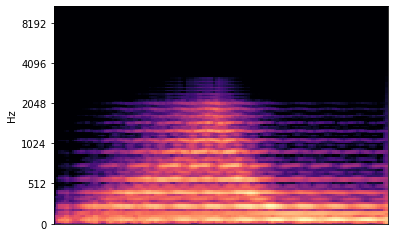

In [11]:
audio_files = glob.glob(audio_dir+'/*.wav')
param_files = glob.glob(param_dir+'/*.pt')
print(len(audio_files), len(param_files))
audio, sr = librosa.load(audio_files[2], sr=16000)
mel = librosa.feature.melspectrogram(y=audio, sr=16000, power=2.0)
mel_db = librosa.power_to_db(mel, np.max)
librosa.display.specshow(mel_db, sr=16000, y_axis='mel')

## Harmor_cffixed
- Harmor_2osc with flanger/chorus
- rate=1Hz depth=0.1
- only mix (0~0.5) and delay_ms (1~40.0 ms) is changed


In [6]:
n_oscs = 2
harmor = Harmor(n_samples=N_SAMPLES, name='harmor', sep_amp=True, n_oscs=n_oscs)
enva = ADSREnvelope(name='enva', max_value=0.6, channels=2)
envc = ADSREnvelope(name='envc', channels=1)
cf = ChorusFlanger(name='cf', sr=SAMPLERATE, delay_range=(1.0, 40.0))
dag = [
    (enva, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_A', 'attack': 'AT_A', 'decay': 'DE_A', 'sus_level': 'SU_A', 'release': 'RE_A', 'note_off': 'NO', 'noise_mag': 'NOISE_A'}),
    (envc, {'floor': 'CUT_FLOOR', 'peak': 'PEAK_C', 'attack': 'AT_C', 'decay': 'DE_C', 'sus_level': 'SU_C', 'release': 'RE_C', 'note_off': 'NO', 'noise_mag': 'NOISE_C'}),
    (harmor, {'amplitudes': 'enva', 'osc_mix': 'M_OSC', 'f0_hz': 'BFRQ', 'f0_mult': 'MULT', 'cutoff': 'envc', 'q': 'Q_FILT'}),
    (cf, {'audio': 'harmor', 'delay_ms': 'CF_DELAY', 'rate': 'CF_RATE', 'depth': 'CF_DEPTH', 'mix': 'CF_MIX'})
    ]
fixed_params = {'AMP_FLOOR':torch.zeros(1), 'NO': torch.ones(1)*NOTE_OFF, 'CF_RATE': torch.ones(1), 'CF_DEPTH': torch.ones(1)*0.1}
synth = Synthesizer(dag, fixed_params=fixed_params, static_params=['BFRQ', 'MULT', 'M_OSC', 'Q_FILT', 'NOISE_A', 'NOISE_C', 'CF_DELAY', 'CF_MIX']).to('cuda')
save_params = ['harmor_amplitudes', 'harmor_osc_mix', 'harmor_f0_hz', 'harmor_f0_mult', 'harmor_cutoff', 'harmor_q', 'cf_delay_ms', 'cf_mix']

In [7]:
audio_dir, param_dir = make_dirs('harmor_cffixed')
# render_dataset(synth, save_params, audio_dir, param_dir)

20000 20000


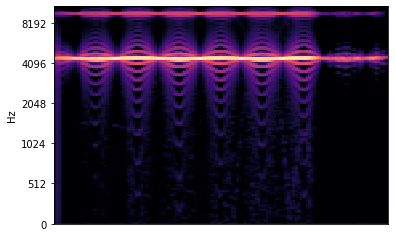

In [9]:
audio_files = glob.glob(audio_dir+'/*.wav')
param_files = glob.glob(param_dir+'/*.pt')
print(len(audio_files), len(param_files))
audio, sr = librosa.load(audio_files[11], sr=16000)
mel = librosa.feature.melspectrogram(y=audio, sr=16000, power=2.0)
mel_db = librosa.power_to_db(mel, np.max)
librosa.display.specshow(mel_db, sr=16000, y_axis='mel')

In [10]:
param = torch.load(param_files[0])
param.keys()

dict_keys(['harmor_amplitudes', 'harmor_osc_mix', 'harmor_f0_hz', 'harmor_f0_mult', 'harmor_cutoff', 'harmor_q', 'cf_delay_ms', 'cf_mix'])

## Harmor_rev
- Harmor_2osc with reverb
    - decay
    - gain


In [6]:
n_oscs = 2
harmor = Harmor(n_samples=N_SAMPLES, name='harmor', sep_amp=True, n_oscs=n_oscs)
enva = ADSREnvelope(name='enva', max_value=0.6, channels=2)
envc = ADSREnvelope(name='envc', channels=1)
reverb = DecayReverb(name='reverb', ir_length=16000)
dag = [
    (enva, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_A', 'attack': 'AT_A', 'decay': 'DE_A', 'sus_level': 'SU_A', 'release': 'RE_A', 'note_off': 'NO', 'noise_mag': 'NOISE_A'}),
    (envc, {'floor': 'CUT_FLOOR', 'peak': 'PEAK_C', 'attack': 'AT_C', 'decay': 'DE_C', 'sus_level': 'SU_C', 'release': 'RE_C', 'note_off': 'NO', 'noise_mag': 'NOISE_C'}),
    (harmor, {'amplitudes': 'enva', 'osc_mix': 'M_OSC', 'f0_hz': 'BFRQ', 'f0_mult': 'MULT', 'cutoff': 'envc', 'q': 'Q_FILT'}),
    (reverb, {'audio': 'harmor', 'gain': 'RE_GAIN', 'decay': 'RE_DECAY'})
    ]
fixed_params = {'AMP_FLOOR':torch.zeros(1), 'NO': torch.ones(1)*NOTE_OFF}
synth = Synthesizer(dag, fixed_params=fixed_params, static_params=['BFRQ', 'MULT', 'M_OSC', 'Q_FILT', 'NOISE_A', 'NOISE_C', 'RE_GAIN', 'RE_DECAY']).to('cuda')
save_params = ['harmor_amplitudes', 'harmor_osc_mix', 'harmor_f0_hz', 'harmor_f0_mult', 'harmor_cutoff', 'harmor_q', 'reverb_gain', 'reverb_decay']

In [7]:
audio_dir, param_dir = make_dirs('harmor_rev')
render_dataset(synth, save_params, audio_dir, param_dir)

100%|██████████| 20000/20000 [13:09<00:00, 25.34it/s]skipped 5290 quiet sounds



20000 20000


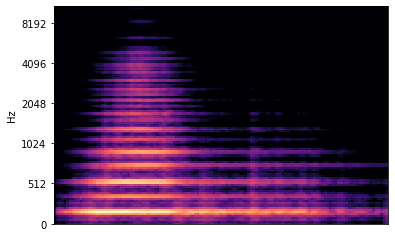

In [9]:
audio_files = glob.glob(audio_dir+'/*.wav')
param_files = glob.glob(param_dir+'/*.pt')
print(len(audio_files), len(param_files))
audio, sr = librosa.load(audio_files[40], sr=16000)
mel = librosa.feature.melspectrogram(y=audio, sr=16000, power=2.0)
mel_db = librosa.power_to_db(mel, np.max)
librosa.display.specshow(mel_db, sr=16000, y_axis='mel')

## Use Envelope

In [7]:
n_oscs = 2
harmor = Harmor(n_samples=N_SAMPLES, name='harmor', sep_amp=True, n_oscs=n_oscs)
enva = ADSREnvelope(name='enva', max_value=0.6, channels=2)
envc = ADSREnvelope(name='envc', channels=1)
cf = ChorusFlanger(name='cf', sr=SAMPLERATE, delay_range=(1.0, 40.0))
dag = [
    (enva, {'floor': 'AMP_FLOOR', 'peak': 'PEAK_A', 'attack': 'AT_A', 'decay': 'DE_A', 'sus_level': 'SU_A', 'release': 'RE_A', 'note_off': 'NO', 'noise_mag': 'NOISE_A'}),
    (envc, {'floor': 'CUT_FLOOR', 'peak': 'PEAK_C', 'attack': 'AT_C', 'decay': 'DE_C', 'sus_level': 'SU_C', 'release': 'RE_C', 'note_off': 'NO', 'noise_mag': 'NOISE_C'}),
    (harmor, {'amplitudes': 'enva', 'osc_mix': 'M_OSC', 'f0_hz': 'BFRQ', 'f0_mult': 'MULT', 'cutoff': 'envc', 'q': 'Q_FILT'}),
    (cf, {'audio': 'harmor', 'delay_ms': 'CF_DELAY', 'rate': 'CF_RATE', 'depth': 'CF_DEPTH', 'mix': 'CF_MIX'})
    ]
fixed_params = {'AMP_FLOOR':torch.zeros(1), 'NO': torch.ones(1)*NOTE_OFF, 'CF_RATE': torch.ones(1), 'CF_DEPTH': torch.ones(1)*0.1, 'NOISE_A':torch.zeros(1), 'NOISE_C':torch.zeros(1)}
synth = Synthesizer(dag, fixed_params=fixed_params, static_params=['BFRQ', 'MULT', 'M_OSC', 'Q_FILT', 'NOISE_A', 'NOISE_C', 'CF_DELAY', 'CF_MIX']).to('cuda')
save_params = ['enva_peak', 'enva_attack', 'enva_decay', 'enva_sus_level', 'enva_release', 'envc_peak', 'envc_attack', 'envc_decay', 'envc_sus_level', 'envc_release', 'harmor_osc_mix', 'harmor_f0_hz', 'harmor_f0_mult', 'harmor_q', 'cf_delay_ms', 'cf_mix']

In [8]:
audio_dir, param_dir = make_dirs('harmor_cffenv')
render_dataset(synth, save_params, audio_dir, param_dir)

100%|██████████| 20000/20000 [05:15<00:00, 63.30it/s]skipped 6982 quiet sounds

